In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from seaborn import kdeplot
import numpy as np
import zipfile

In [2]:
import scipy.stats as sp
import patsy as pt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.neighbors import KernelDensity

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [4]:
zipf = (['PNADC_012022_20220916', 'Dados_20170517'], 
        ['Dicionario_e_input_20220224', 'Dicionarios_e_input_20170517'])
subd_arch = (['', '/Dicionários e input', '/Dados'], ['dicionario_PNADC_microdados_trimestral', 
                                         'Dicionário de variáveis de pessoas - PNAD 2015',
                                         'Dicionário de variáveis de domicílios - PNAD 2015'], ['PNADC_012022',
                                                                                                'DOM2015', 'PES2015'])

In [5]:
with zipfile.ZipFile(f'C:/DATASETS/IBGE/PNAD/{zipf[1][0]}.zip') as z:
    df_dict = pd.read_excel(z.open(f'{subd_arch[0][0]}{subd_arch[1][0]}.xls'), header=None, 
                          skiprows=4, dtype='string').dropna(how='all')[[0, 1, 2, 4, 5, 6]]

    sizes = df_dict[1][df_dict[1].str.isnumeric()].astype(int).values
    positions = df_dict[0][df_dict[0].str.isnumeric()].astype(int).values-1
    final_pos = [i[0]+i[1] for i in zip(positions, sizes)]
    final_pos[220], final_pos= 3478, final_pos[0:220]
    tuples = list(zip(positions, final_pos)) #dicionário de variáveis e tamanhos das colunas

with zipfile.ZipFile(f'C:/DATASETS/IBGE/PNAD/{zipf[0][0]}.zip') as z:
    pnad = pd.read_fwf(z.open(f'{subd_arch[0][0]}{subd_arch[2][0]}.txt'), 
                          colspecs=tuples, header=None, nrows=500000, dtype=str)

df_dict[5].fillna('0', inplace=True)
df_dict[2].fillna(method='ffill', inplace=True)
df_dict.set_index(2, inplace=True)
df_dict.index = df_dict.index.str.lower()
pnad.columns = list(df_dict.index.str.lower().dropna().unique()[0:220]) #dataset carregado

In [6]:
def unique_labels(df, i, c):
        return i if c==df.columns[0] else None

In [7]:
def cat_dict(df, var): #substituir códigos pelo nome da categoria
    catDict = dict()
    for n, cat in enumerate(df_dict.loc[var][5]):
        catDict[cat] = df_dict.loc[var][6][n]
    return {var.lower(): catDict}[var]

In [8]:
def filtragem(df, grupo=dict()):

    filtros = list()
    for i in grupo.items():
        if type(i[1])==list:
            if i[1][-1]=='int':
                for n in i[1][:-1]:
                    filtros.append(((df[i[0]].dropna().astype(int)>=i[1][0])&(df[i[0]].dropna().astype(int)<=i[1][1])))
            elif i[1][-1]=='category':
                    filtros.append(pd.Series([x in i[1] for x in df[i[0]].dropna().astype('int32')]))
        else:
            filtros.append((df[i[0]]==i[1]))
    
    mask = filtros[0]
    for i in filtros:
        mask = mask&i
    
    return mask

In [9]:
def plot_distribution(df, var=str(), var_cross=dict(), bins=7, remove_cats=list(), density=False, n=2, save=False, name=''):
    ax, fig = plt.subplots(figsize=(12,6), facecolor='#063e58')
    
    keys = list(var_cross.keys())+[var]
    filtro = filtragem(df,var_cross)
    df = df[filtro][keys]
    
    for i in df[keys[n]].unique():
        fig.hist(df[df[keys[n]]==i][var].astype(int), 
                 alpha=1/len(df[keys[n]].unique()), density=density, bins=bins)
    
    plt.ylabel('Frequência'), plt.xlabel('Anos estudados')
    ax2 = ax.gca().twinx()
    
    for i in df[keys[n]].unique():
        kdeplot(df[df[keys[n]]==i][var].astype(int),
                label=cat_dict(df_dict, keys[n])[str(i)])
    
    plt.title(f'Anos estudados por {keys[n]} | {len(df)} observações')
    fig.set_facecolor('#063e58')
    ax2.set_ylabel('Densidade')
    plt.legend()
    plt.show()
    
    if save:
        plt.savefig(f'graficos/distribuicao_{var}_{name}.png')

In [10]:
def amostragem(df, y='vd3005', grupoA=dict(), grupoB=dict()):
    global var
    var = y
    cols = list(grupoA.keys())
    dfA = df[filtragem(df, grupo=grupoA)][cols+['upa', 'estrato', 'v1008', var]]
    dfB = df[filtragem(df, grupo=grupoB)][cols+['upa', 'estrato', 'v1008', var]]
    return dfA, dfB

In [11]:
def moradores_mesmo_domicilio(dfA, dfB, pareado=False):
    for i in [dfA, dfB]: #unificando campos que identificam domicílios em uma primary key
        i['key'] = i['upa']+i['estrato']+i['v1008']
        i.drop(['upa','estrato','v1008'], axis=1, inplace=True)

    df_ab = dfA.merge(dfB, on='key', suffixes=['_r', '_f'])
    
    if pareado:
        series = list()
        columns = [x for x in df_ab.columns if x[-2:]!='_f']
    
        for col in columns:
            if col!='key':
                s = pd.concat([df_ab[col], df_ab[col[:-2]+'_f']]) #concatenando em uma série as variáveis
                series.append(s)
            else:
                s = pd.concat([df_ab[col], df_ab[col]])
                series.append(s)

        df_ab = pd.concat(series, axis=1, ignore_index=True)
        df_ab.columns = [x[:-2] if x[-2:]=='_r' else x for x in columns]

        return df_ab.drop_duplicates().reset_index(drop=True)
    
    else:
        return df_ab

In [12]:
def discretize(df, var, n_bins=4):
    n_cats = np.linspace(0, df[var].dropna().astype(int).max(), n_bins)
    labels= [str(int(x//1))+'a'+str(int(n_cats[n+1]//1)) for n, x in enumerate(n_cats) if x!=max(n_cats)]
    df[var+'_c'] = pd.cut(df[var].dropna().astype(int), bins=n_cats, labels=labels, include_lowest=True)
    
    return df

In [13]:
def plot_contingencyBar(df, cats, var, normalize):
    
    XvsY = pd.crosstab(df[cats], df[var], normalize=normalize)
    
    ax, fig = plt.subplots(figsize=(12,6), facecolor='#063e58')
    color_list = list(matplotlib.colors.cnames)
    nv, nc = len(XvsY.columns), len(XvsY.index)
    width = 1
    dist = 0
    cluster = -1
    place_labels = [[],[]]
    for col in XvsY.columns:
        color = 10
        cluster += 1
        for ind in XvsY.index:
            place_labels[0].append(cluster+dist)
            place_labels[1].append(ind)
            chart = plt.bar(cluster+dist, round(XvsY.loc[ind, col]*100, 2), width=width, color=color_list[color], 
                            label=unique_labels(XvsY, ind, col))
            dist+=width
            color+=1
            plt.bar_label(chart, label_type='center')
    plt.title(f'{var} x {cats} | normalização: {normalize} | n observações: {len(df)}')
    fig.set_facecolor('#063e58')
    plt.xticks(place_labels[0], place_labels[1], rotation=45)
    plt.ylabel('%', y=0.95)
    plt.legend()
    
    plt.show()

In [14]:
def cruzamento_2variaveis(df, group, var, var_2, normalize='columns', save=False):
    check_zeros = lambda x : '' if x==0 else x
    
    XvsYZ = pd.crosstab([amostra[var], amostra[var_2]], amostra[group], normalize=normalize)
    ng = len(XvsYZ.columns)
    nv = len(XvsYZ.index.get_level_values(0))
    nv2 = len(XvsYZ.index.get_level_values(1))
    ax, fig = plt.subplots(figsize=(12,6), facecolor='#063e58')
    color_list = list(matplotlib.colors.cnames)
    
    leg, dist = True, 0
    place_labels = [[],[]]
    for col in XvsYZ.columns:
        for ind in XvsYZ.index.get_level_values(0).unique():
            place_labels[0].append(dist)
            place_labels[1].append(ind)
            bottom = 0
            color = 11
            for i in XvsYZ.index.get_level_values(1).unique():
                chart = (fig.bar(dist, round(XvsYZ.loc[ind, col][i]*100, 2), bottom=bottom, width=1, 
                                 color=color_list[color], label= cat_dict(df_dict, var_2)[i] if leg==True else ''))
                plt.bar_label(chart, label_type='center')
                bottom += round(XvsYZ.loc[ind, col][i]*100, 2)
                color += 1
            dist+=1
            leg = False
        dist+=1
    
    plt.ylabel('%', y=0.95)
    newax = ax.gca().twiny()
    newax.bar(place_labels[0], [0]*len(place_labels[0]))
    newax.set_frame_on(True)
    newax.xaxis.set_ticks_position('bottom')
    newax.xaxis.set_label_position('bottom')
    newax.spines['bottom'].set_position(('outward', 40))

    cut = int(np.floor(len(place_labels[0])/2))
    plt.title(f'Anos estudados de pais e filhos por sexo | normalização: {normalize} | n observações: {len(df)}')
    fig.legend()
    fig.set_facecolor('#063e58')
    fig.set_xticks(place_labels[0], place_labels[1], rotation=45)
    newax.set_xticks([np.median(place_labels[0][:cut])]+[np.median(place_labels[0][cut:])], ['Responsáveis', 'Filhos'])
    newax.set_xlabel('Grupos')
    plt.show()
    
    if save:
        plt.savefig(f'graficos/distribuicao_anos_est_{var}_{var_2}.png')

### Selecionando a amostra

In [15]:
a={'v2005':[1, 'category'], 'v2009':[25, 130,'int'], 'v2010': [1, 2, 4, 'category'], 'v2007': [1, 2, 'category']} #responsáveis
b={'v2005':[4, 5, 'category'], 'v2009':[25, 130,'int'], 'v2010': [1, 2, 4, 'category'], 'v2007': [1, 2, 'category']} ##filhos

In [16]:
c = {'v2005':[1, 4, 'category'], 'v2009': [20, 40, 'int'], 'v2007': [1, 2, 'category'], 'v2010': [1, 2, 3, 4, 'category']}

In [17]:
amostra = pnad.pipe(amostragem, grupoA=a, grupoB=b, y='vd3005')[0]\
    .pipe(moradores_mesmo_domicilio, amostragem(pnad, grupoA=a, grupoB=b, y='vd3005')[1], pareado=True)\
    .pipe(discretize, 'vd3005', n_bins=6)

In [18]:
amostra

,v2005,v2009,v2010,v2007,vd3005,key,vd3005_c
0,01,045,2,2,10,110000016111001102,9a12
1,01,053,1,2,12,110000016111001113,9a12
2,01,056,4,2,11,110000016111001114,9a12
3,01,076,4,2,05,110000052115201207,3a6
4,01,063,4,2,00,110000108111001203,0a3
...,...,...,...,...,...,...,...
55574,05,034,4,1,13,530059517531021106,12a16
55575,04,027,1,2,12,530059517531021110,9a12
55576,05,031,4,1,10,530059517531021112,9a12
55577,05,042,1,2,12,530059580531011204,9a12


In [19]:
amostra['v2005'] = amostra['v2005'].apply(lambda x : '01' if x=='01' else '04')

### Plotando gráficos

In [20]:
amostra.head()

,v2005,v2009,v2010,v2007,vd3005,key,vd3005_c
0,01,045,2,2,10,110000016111001102,9a12
1,01,053,1,2,12,110000016111001113,9a12
2,01,056,4,2,11,110000016111001114,9a12
3,01,076,4,2,05,110000052115201207,3a6
4,01,063,4,2,00,110000108111001203,0a3


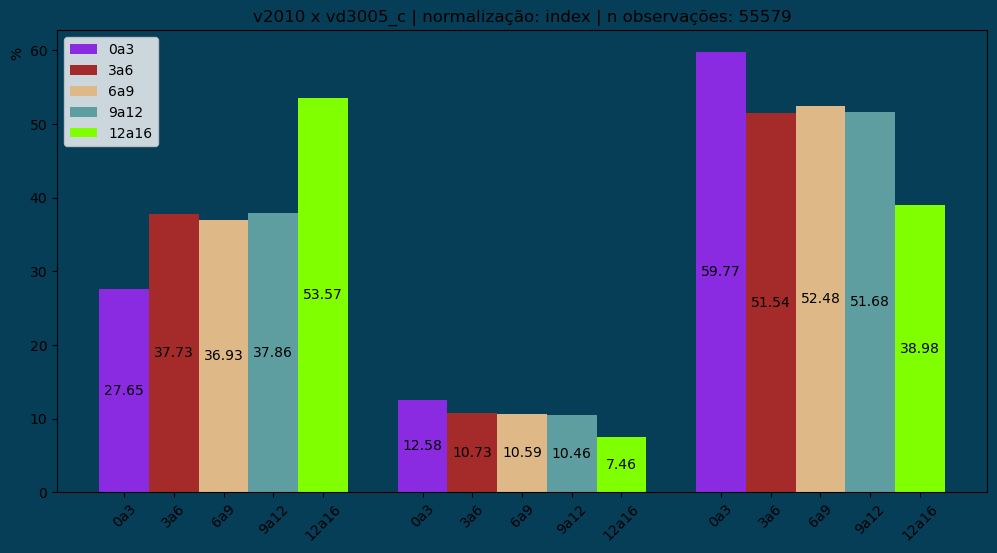

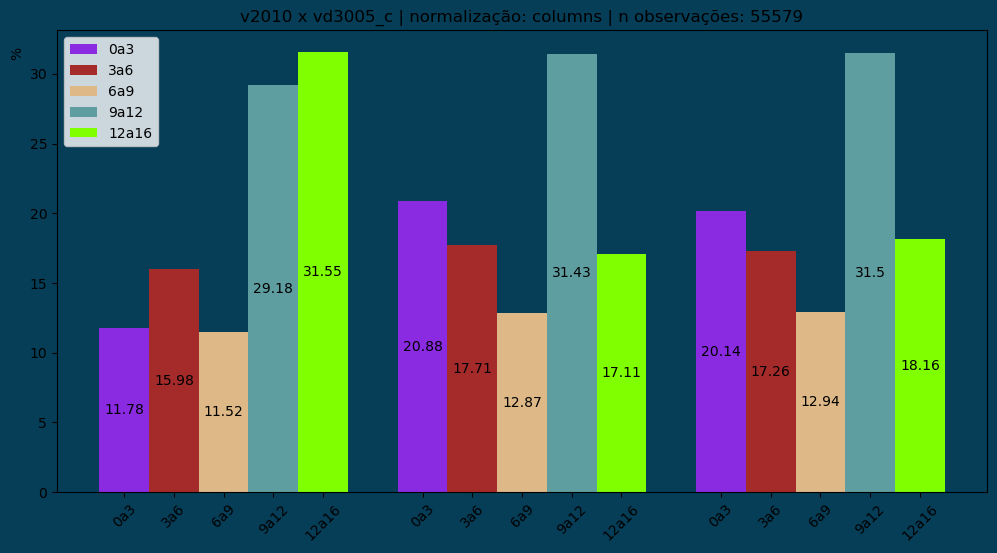

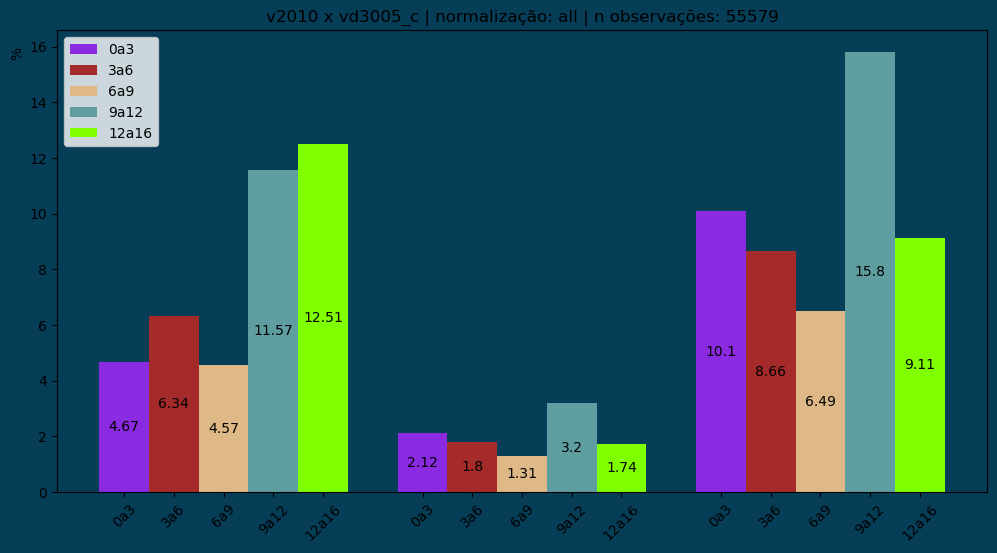

In [21]:
for p in ['index','columns', 'all']:
    plot_contingencyBar(amostra, cats='vd3005_c', var='v2010', normalize=p)

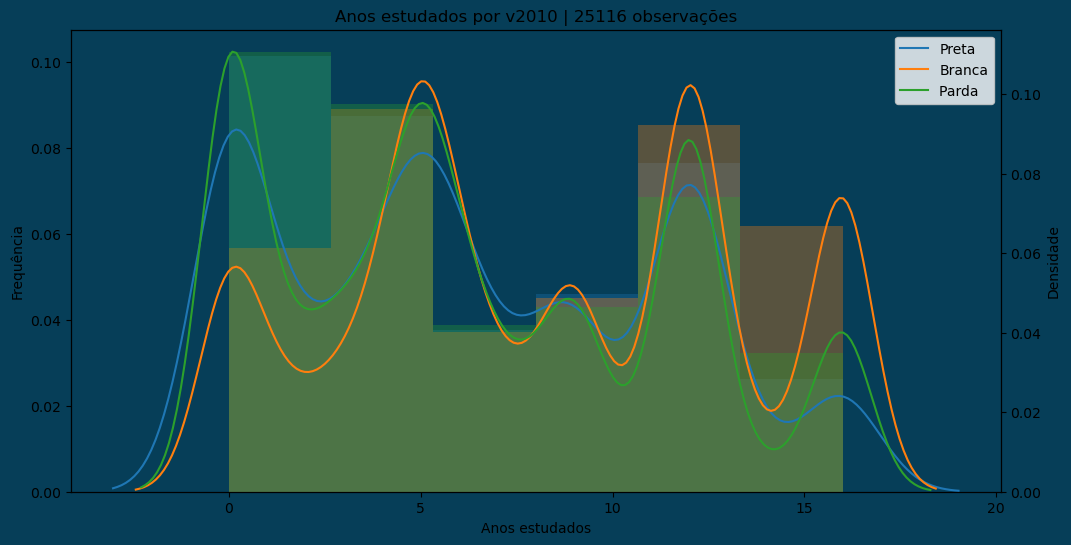

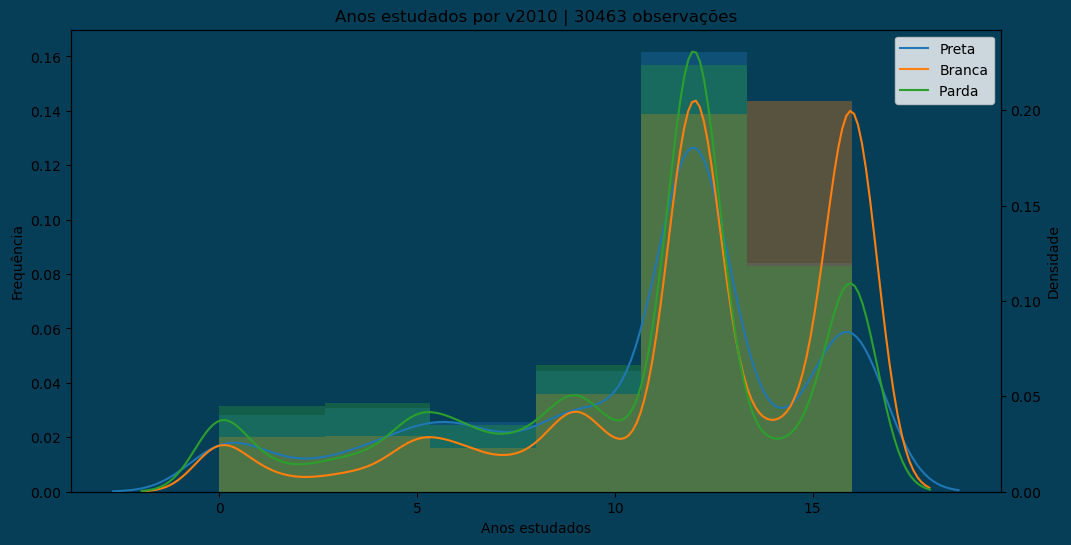

In [22]:
for d in [a, b]:
    plot_distribution(amostra, var='vd3005', var_cross=d, bins=6, density=True, n=2, save=False, name=d['v2005'][0])

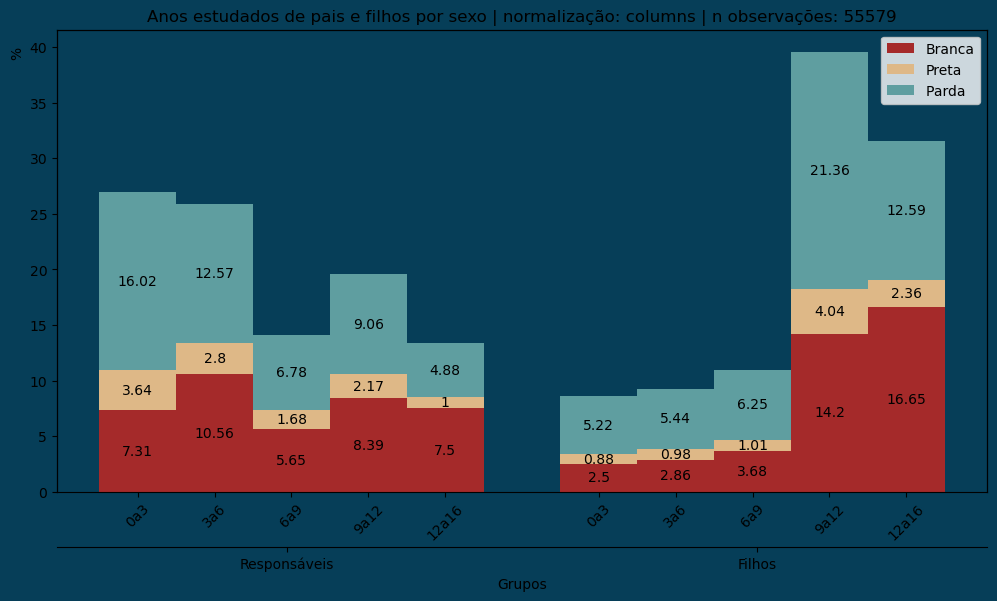

In [23]:
cruzamento_2variaveis(amostra, group='v2005', var='vd3005_c', var_2='v2010', normalize='columns', save=False)

In [24]:
amostra = pnad.pipe(amostragem, grupoA=a, grupoB=b, y='vd3005')[0]\
    .pipe(moradores_mesmo_domicilio, amostragem(pnad, grupoA=a, grupoB=b, y='vd3005')[1], pareado=False)\
    .pipe(discretize, 'vd3005_r', n_bins=6)

In [25]:
amostra = discretize(amostra, 'vd3005_r', n_bins=5)
amostra['diff'] = amostra['vd3005_f'].astype(int) - amostra['vd3005_r'].astype(int)

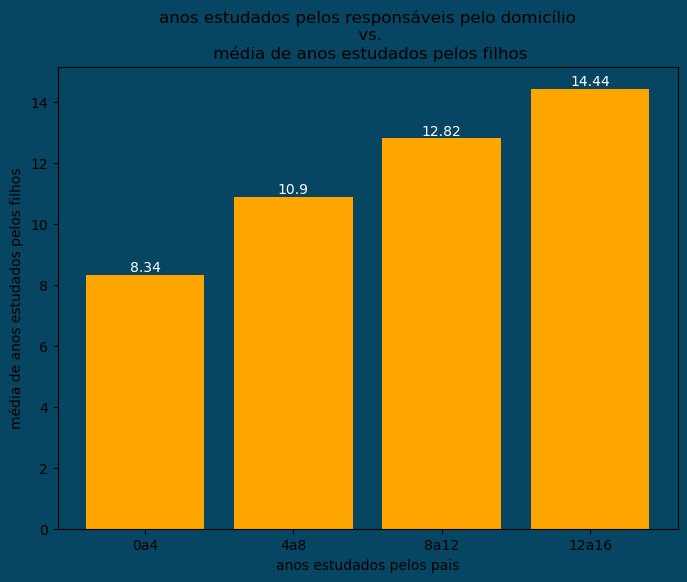

In [26]:
ax, fig = plt.subplots(figsize=(8,6), facecolor='#074663')
fig.set_facecolor('#074663')
for i in ['0a4', '4a8','8a12', '12a16']:
    chart = (plt.bar(i, round(amostra[(amostra['vd3005_r_c']==i)
#                                                  &
#                                      (amostra['v2010_f']=='1')
                                         ]['vd3005_f'].astype(int).mean(), 2), color='orange'))
    plt.bar_label(chart, label_type='edge', color='white')

plt.title('anos estudados pelos responsáveis pelo domicílio\n vs.\n média de anos estudados pelos filhos')
plt.ylabel('média de anos estudados pelos filhos')
plt.xlabel('anos estudados pelos pais')
#plt.xticks([0, 1, 2, 3], ['0a4', '5a8', '9a12', '13a16'])
plt.show()

In [27]:
means = list()
for i in ['0a4','4a8', '8a12' , '12a16']:
    means.append(amostra[amostra['vd3005_r_c']==i]['vd3005_f'].astype(int).mean())

In [28]:
print(means)
np.mean([x-means[n-1] for n, x in enumerate(means) if n!=0])

[8.335229501765399, 10.904597983771822, 12.818778088181707, 14.437106125535669]


2.03395887459009

In [29]:
amostra[['v2005_r', 'vd3005_r_c', 'key',
       'v2005_f', 'vd3005_f']].rename(columns={'v2005_r':'responsável', 'vd3005_r_c':'anos_estudados_responsavel',
                                      'v2005_f':'filho', 'vd3005_f':'anos_estudados_filho'}).\
                replace({'4a8': '5a8', '8a12':'9a12', '12a16':'13a16'})

,responsável,anos_estudados_responsavel,key,filho,anos_estudados_filho
0,01,9a12,110000016111001102,05,10
1,01,9a12,110000016111001113,05,16
2,01,9a12,110000016111001114,05,16
3,01,5a8,110000052115201207,05,12
4,01,0a4,110000108111001203,05,12
...,...,...,...,...,...
30525,01,5a8,530059517531021106,05,13
30526,01,0a4,530059517531021110,04,12
30527,01,9a12,530059517531021112,05,10
30528,01,9a12,530059580531011204,05,12


### Exclusão escolar

In [30]:
pnad.insert(0, 'key', pnad['upa']+pnad['estrato']+pnad['v1008'])
pnad.drop(['upa', 'estrato', 'v1008'], axis=1, inplace=True)

In [31]:
exclusao = pnad[(pnad['v2009'].astype(int)>4)&(pnad['v2009'].astype(int)<18)
         &([x not in ['5', '6', '7'] for x in pnad['vd3004']])
         &(pnad['v2010']!='9')     
               ][['key', 'uf', 'v3002', 'v2009', 'v2007', 'v2010', 'v4001', 'v4002']]
exclusao['trabalha'] = ['1' if x[0]=='1' or x[1]=='1' else '2' for x in zip(exclusao['v4001'], exclusao['v4002'])]
exclusao['v2010'] = ['outros' if x=='3' or x=='5' else x for x in exclusao['v2010']]
exclusao.reset_index(drop=True, inplace=True)

In [32]:
pnad['v403312'] = pnad['v403312'].dropna().astype(int)
renda_dom = pnad[['key', 'v403312']].groupby('key').sum()

exclusao = exclusao.merge(renda_dom, on='key', how='left')

exclusao['v403312_c'] = pd.cut(exclusao['v403312'], bins=[0, 606, 1212, 2424, 3636, 6060, 12120, 24240, 500000],
                                                    labels=['1', '2', '3', '4', '5', '6', '7', '8'])

In [33]:
exclusao_desag = exclusao.groupby(['v403312_c', 'v2010', 'v2007', 'v3002']).count()[['key']]

for obs1 in exclusao_desag.index.get_level_values(0).unique():
    for obs2 in exclusao_desag.index.get_level_values(1).unique():
        for obs3 in exclusao_desag.index.get_level_values(2).unique():
            print(f'--{obs1}--{obs2}--{obs3}--')
            for obs4 in exclusao_desag.index.get_level_values(3).unique():
                print(str(obs4), round((exclusao_desag.loc[obs1].loc[obs2].loc[obs3].loc[obs4]
                                /
                exclusao_desag.loc[obs1].loc[obs2].loc[obs3].sum()) * 100, 2).values)

--1--1--1--
1 [95.13]
2 [4.87]
--1--1--2--
1 [96.44]
2 [3.56]
--1--2--1--
1 [94.85]
2 [5.15]
--1--2--2--
1 [95.9]
2 [4.1]
--1--4--1--
1 [95.68]
2 [4.32]
--1--4--2--
1 [96.58]
2 [3.42]
--1--outros--1--
1 [92.59]
2 [7.41]
--1--outros--2--
1 [89.71]
2 [10.29]
--2--1--1--
1 [96.08]
2 [3.92]
--2--1--2--
1 [96.53]
2 [3.47]
--2--2--1--
1 [97.85]
2 [2.15]
--2--2--2--
1 [96.37]
2 [3.63]
--2--4--1--
1 [95.89]
2 [4.11]
--2--4--2--
1 [96.48]
2 [3.52]
--2--outros--1--
1 [92.11]
2 [7.89]
--2--outros--2--
1 [92.31]
2 [7.69]
--3--1--1--
1 [97.18]
2 [2.82]
--3--1--2--
1 [97.74]
2 [2.26]
--3--2--1--
1 [95.87]
2 [4.13]
--3--2--2--
1 [96.98]
2 [3.02]
--3--4--1--
1 [96.43]
2 [3.57]
--3--4--2--
1 [96.73]
2 [3.27]
--3--outros--1--
1 [97.22]
2 [2.78]
--3--outros--2--
1 [96.7]
2 [3.3]
--4--1--1--
1 [98.01]
2 [1.99]
--4--1--2--
1 [98.15]
2 [1.85]
--4--2--1--
1 [95.33]
2 [4.67]
--4--2--2--
1 [98.55]
2 [1.45]
--4--4--1--
1 [97.29]
2 [2.71]
--4--4--2--
1 [97.61]
2 [2.39]
--4--outros--1--
1 [95.45]
2 [4.55]
--4--ou

In [34]:
exclusao['regiao'] = exclusao['uf'].apply(lambda x: 
               'norte' if x[0]=='1' else
               'nordeste' if x[0]=='2' else
                'sudeste' if x[0]=='3' else
                'centro-oeste' if x[0]=='4' else
                'sul')

In [40]:
ct = pd.crosstab(exclusao[(exclusao['v2009'].astype(int)>=14)]['v3002'], 
            [exclusao[(exclusao['v2009'].astype(int)>=14)]['v2010'],
             exclusao[(exclusao['v2009'].astype(int)>=14)]['v2007'], 
             exclusao[(exclusao['v2009'].astype(int)>=14)]['trabalha'].rename('v4001')],
              normalize='columns', colnames=['cor','gênero','trabalha'], rownames=['frequenta escola'])\
                                                    .rename(cat_dict(df_dict, 'v2010'), axis=1, level=0)\
                                                    .rename(cat_dict(df_dict, 'v2007'), axis=1, level=1)\
                                                    .rename(cat_dict(df_dict, 'v4001'), axis=1)\
                                                    .rename(cat_dict(df_dict, 'v3002'))

In [41]:
#cruzamento das variáveis cor/raça; gênero; trabalho

ct

cor                 Branca                                  Preta            \
gênero               Homem             Mulher               Homem             
trabalha               Sim      Não       Sim      Não        Sim      Não    
frequenta escola                                                              
Sim               0.859539  0.968491  0.96988  0.969137  0.841727  0.948571   
Não               0.140461  0.031509  0.03012  0.030863  0.158273  0.051429   

cor                                     Parda                                 \
gênero              Mulher               Homem              Mulher             
trabalha               Sim      Não        Sim      Não        Sim      Não    
frequenta escola                                                               
Sim               0.941176  0.957635  0.833333  0.955026  0.923977  0.952759   
Não               0.058824  0.042365  0.166667  0.044974  0.076023  0.047241   

cor              outros                            
gênero            Homem           Mulher           
trabalha            Sim      Não     Sim     Não   
frequenta escola                                   
Sim                 0.7  0.943548    0.8  0.92126  
Não                 0.3  0.056452    0.2  0.07874

In [42]:
#cruzamento das variáveis cor/raça; gênero; renda

pd.crosstab(exclusao['v3002'], 
            [exclusao['v2010'],
             exclusao['v2007'], 
             exclusao['v403312_c'].rename('v403312')], normalize='columns',
             colnames=['cor','gênero','renda familiar'], rownames=['frequenta escola'])\
                                .rename(cat_dict(df_dict, 'v2010'), axis=1, level=0)\
                                .rename(cat_dict(df_dict, 'v2007'), axis=1, level=1)\
                                .rename(cat_dict(df_dict, 'v403312'), axis=1)\
                                .rename(cat_dict(df_dict, 'v3002')) * 100

cor                  Branca                                              \
gênero                Homem                                               
renda familiar            1          2          3          4          5   
frequenta escola                                                          
Sim               95.129225  96.082949  97.184466  98.010775  98.195489   
Não                4.870775   3.917051   2.815534   1.989225   1.804511   

cor                                                                      \
gênero                                                Mulher              
renda familiar            6          7          8          1          2   
frequenta escola                                                          
Sim               98.786127  99.687011  99.166667  96.443966  96.530148   
Não                1.213873   0.312989   0.833333   3.556034   3.469852   

cor                                                                      \
gênero                                                                    
renda familiar            3          4          5          6          7   
frequenta escola                                                          
Sim               97.744622  98.150483  98.935331  98.269468  99.503311   
Não                2.255378   1.849517   1.064669   1.730532   0.496689   

cor                              Preta                                   \
gênero                           Homem                                    
renda familiar            8          1          2          3          4   
frequenta escola                                                          
Sim               99.568966  94.847775  97.849462  95.870968  95.327103   
Não                0.431034   5.152225   2.150538   4.129032   4.672897   

cor                                                                  \
gênero                                                       Mulher   
renda familiar            5          6          7      8          1   
frequenta escola                                                      
Sim               98.165138  99.275362  97.142857  100.0  95.899054   
Não                1.834862   0.724638   2.857143    0.0   4.100946   

cor                                                                      \
gênero                                                                    
renda familiar            2          3          4          5          6   
frequenta escola                                                          
Sim               96.367113  96.982759  98.547215  98.784195  99.206349   
Não                3.632887   3.017241   1.452785   1.215805   0.793651   

cor                                Parda                                  \
gênero                              Homem                                  
renda familiar        7      8          1          2         3         4   
frequenta escola                                                           
Sim               100.0  100.0  95.678823  95.893774  96.43451  97.28621   
Não                 0.0    0.0   4.321177   4.106226   3.56549   2.71379   

cor                                                                      \
gênero                                                           Mulher   
renda familiar            5          6          7          8          1   
frequenta escola                                                          
Sim               97.472483  98.948375  99.576271  98.550725  96.582985   
Não                2.527517   1.051625   0.423729   1.449275   3.417015   

cor                                                                      \
gênero                                                                    
renda familiar            2          3          4          5          6   
frequenta escola                                                          
Sim               96.477219  96.730731  97.610106  97.980685  98.710317   
Não                3.522781   3.269

In [43]:
pd.crosstab(exclusao['v3002'], 
            [exclusao['v2010'],
             exclusao['v2007'], 
             exclusao['regiao']], normalize='columns',
             colnames=['cor','gênero','região'], rownames=['frequenta escola'])\
                                .rename(cat_dict(df_dict, 'v2010'), axis=1, level=0)\
                                .rename(cat_dict(df_dict, 'v2007'), axis=1, level=1)\
                                .rename(cat_dict(df_dict, 'v3002')) * 100

cor                    Branca                                              \
gênero                  Homem                                               
região           centro-oeste   nordeste      norte    sudeste        sul   
frequenta escola                                                            
Sim                 97.749469  96.565495  96.986519  98.086124  97.319588   
Não                  2.250531   3.434505   3.013481   1.913876   2.680412   

cor                                                                      \
gênero                 Mulher                                             
região           centro-oeste  nordeste      norte    sudeste       sul   
frequenta escola                                                          
Sim                     98.24  97.46511  96.090696  98.296296  98.00995   
Não                      1.76   2.53489   3.909304   1.703704   1.99005   

cor                     Preta                                              \
gênero                  Homem                                               
região           centro-oeste   nordeste      norte    sudeste        sul   
frequenta escola                                                            
Sim                 95.041322  96.737589  95.539906  96.929825  96.440129   
Não                  4.958678   3.262411   4.460094   3.070175   3.559871   

cor                                                                       \
gênero                 Mulher                                              
região           centro-oeste   nordeste      norte   sudeste        sul   
frequenta escola                                                           
Sim                 98.623853  97.253635  96.590909  98.00222  96.981132   
Não                  1.376147   2.746365   3.409091   1.99778   3.018868   

cor                    Parda                                              \
gênero                  Homem                                              
região           centro-oeste   nordeste      norte    sudeste       sul   
frequenta escola                                                           
Sim                 96.025641  96.872374  94.891558  97.611744  96.50655   
Não                  3.974359   3.127626   5.108442   2.388256   3.49345   

cor                                                                       \
gênero                 Mulher                                              
região           centro-oeste   nordeste      norte   sudeste        sul   
frequenta escola                                                           
Sim                 96.690933  97.325883  95.959596  97.60966  97.028045   
Não                  3.309067   2.674117   4.040404   2.39034   2.971955   

cor                    outros                                            \
gênero                  Homem                                             
região           centro-oeste   nordeste      norte  sudeste        sul   
frequenta escola                                                          
Sim                 97.297297  95.081967  94.478528  95.3125  97.297297   
Não                  2.702703   4.918033   5.521472   4.6875   2.702703   

cor                                                                        
gênero                 Mulher                                              
região           centro-oeste   nordeste      norte    sudeste        sul  
frequenta escola                                                           
Sim                     100.0  95.614035  91.666667  96.774194  92.307692  
Não                       0.0   4.385965   8.333333   3.225806   7.692308